# 安装配置

In [ ]:
!python3 -m pip --version # 查看pip版本
!python -m pip install --upgrade pip #更新pip版本
!python -m pip install paddlepaddle==1.8.5 -i https://mirror.baidu.com/pypi/simple #下载paddle1.8.5版本
# !python -m pip install paddlepaddle==2.0.1 -i https://mirror.baidu.com/pypi/simple

![](https://ai-studio-static-online.cdn.bcebos.com/61c6f63d666f4a81b98171b775ee8d486e610cf8fa654225b5cdd3c4b7db96ce)本项目对应视频课程已上线，点击前往学习[深度学习CV从入门到实战](https://aistudio.baidu.com/aistudio/course/introduce/789)课节2波士顿房价预测

经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 本教程使用PaddlePaddle建立起一个房价预测模型。

在线性回归中：

（1）假设函数是指，用数学的方法描述自变量和因变量之间的关系，它们之间可以是一个线性函数或非线性函数。 在本次线性回顾模型中，我们的假设函数为 Y’= wX+b ，其中，Y’表示模型的预测结果（预测房价），用来和真实的Y区分。模型要学习的参数即：w,b。

（2）损失函数是指，用数学的方法衡量假设函数预测结果与真实值之间的误差。这个差距越小预测越准确，而算法的任务就是使这个差距越来越小。 建立模型后，我们需要给模型一个优化目标，使得学到的参数能够让预测值Y’尽可能地接近真实值Y。这个实值通常用来反映模型误差的大小。不同问题场景下采用不同的损失函数。 对于线性模型来讲，最常用的损失函数就是均方误差（Mean Squared Error， MSE）。

（3）优化算法：神经网络的训练就是调整权重（参数）使得损失函数值尽可能得小，在训练过程中，将损失函数值逐渐收敛，得到一组使得神经网络拟合真实模型的权重（参数）。所以，优化算法的最终目标是找到损失函数的最小值。而这个寻找过程就是不断地微调变量w和b的值，一步一步地试出这个最小值。 常见的优化算法有随机梯度下降法（SGD）、Adam算法等等

**首先导入必要的包**，分别是：

**paddle.fluid**--->PaddlePaddle深度学习框架

**numpy**---------->python基本库，用于科学计算

**os**------------------>python的模块，可使用该模块对操作系统进行操作

In [2]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os

# **Step1：准备数据。**

（1）uci-housing数据集介绍

数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。

PaddlePaddle提供了读取uci_housing训练集和测试集的接口，分别为paddle.dataset.uci_housing.train()和paddle.dataset.uci_housing.test()。

(2)train_reader和test_reader

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

最后在导入matplotlib，避免不必要的报错

**matplotlib**----->python绘图库，可方便绘制折线图、散点图等图形

In [3]:
BUF_SIZE=500 # 每次缓存BUF_SIZE个数据项
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
               buf_size=BUF_SIZE),                    
               batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
              paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
              buf_size=BUF_SIZE),
              batch_size=BATCH_SIZE)


%matplotlib inline
import matplotlib.pyplot as plt
    

Cache file /root/.cache/paddle/dataset/uci_housing/housing.data not found, downloading http://paddlemodels.bj.bcebos.com/uci_housing/housing.data 
Begin to download
............
Download finished


(3)打印看下数据是什么样的？PaddlePaddle接口提供的数据已经经过归一化等处理

(array([-0.02964322, -0.11363636,  0.39417967, -0.06916996,  0.14260276,
       -0.10109875,  0.30715859, -0.13176829, -0.24127857,  0.05489093,
        0.29196451, -0.2368098 ,  0.12850267]), array([15.6])),

In [4]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


# **Step2:网络配置**

**（1）网络搭建**：对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。

对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

![](https://ai-studio-static-online.cdn.bcebos.com/f3f567e7aa7a499fb3abb767aaaa1b943eed373cf4694d87beb382e161ea8edc)

![](https://ai-studio-static-online.cdn.bcebos.com/f6c44a96e1624828829bbd438c29c17ead9ecc45c68b4310bfbbb0a4dc96c3fe)


In [5]:
import paddle
# paddle.enable_static()

In [6]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

**(2)定义损失函数**

此处使用均方差损失函数。

square_error_cost(input,lable):接受输入预测值和目标值，并返回方差估计,即为（y-y_predict）的平方

In [7]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

**(3)定义优化函数**

此处使用的是随机梯度下降。

In [8]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [9]:
test_program = fluid.default_main_program().clone(for_test=True)

在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入**fluid.default_startup_program()**

**fluid.default_main_program**()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

# **Step3.模型训练** and **Step4.模型评估**

**（1）创建Executor**

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [10]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]




**（2）定义输入数据维度**

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [11]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

**（3）定义绘制训练过程的损失值变化趋势的方法draw_train_process**

In [12]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

**（4）训练并保存模型**

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

注：enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，

Pass:0, Cost:661.71851
Test:0, Cost:250.37146
Pass:1, Cost:636.22180
Test:1, Cost:450.08057
Pass:2, Cost:573.06824
Test:2, Cost:105.32194
Pass:3, Cost:426.53149
Test:3, Cost:210.61501
Pass:4, Cost:427.78192
Test:4, Cost:202.50958
Pass:5, Cost:622.64880
Test:5, Cost:312.19897
Pass:6, Cost:490.78964
Test:6, Cost:222.89038
Pass:7, Cost:319.67731
Test:7, Cost:118.99060
Pass:8, Cost:456.64005
Test:8, Cost:165.09912
Pass:9, Cost:311.35681
Test:9, Cost:28.96415
Pass:10, Cost:215.64799
Test:10, Cost:137.52866
Pass:11, Cost:224.69449
Test:11, Cost:77.89358
Pass:12, Cost:266.58337
Test:12, Cost:70.73208
Pass:13, Cost:117.09991
Test:13, Cost:138.25931
Pass:14, Cost:328.45108
Test:14, Cost:20.90673
Pass:15, Cost:510.35791
Test:15, Cost:74.77946
Pass:16, Cost:307.30957
Test:16, Cost:202.54591
Pass:17, Cost:196.98709
Test:17, Cost:84.18390
Pass:18, Cost:220.86649
Test:18, Cost:9.99421
Pass:19, Cost:303.66327
Test:19, Cost:33.61822
Pass:20, Cost:112.60679
Test:20, Cost:178.96178
Pass:21, Cost:215.813

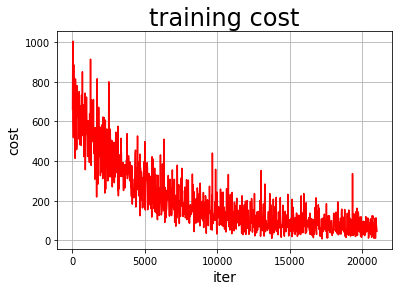

In [13]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)


# **Step5.模型预测**

**（1）创建预测用的Executor**

In [14]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**（2）可视化真实值与预测值方法定义**

In [15]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths, infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results, color='green',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results and ground truth: (House Price)
0: infer:13.32   gt:8.50
1: infer:13.45   gt:5.00
2: infer:13.31   gt:11.90
3: infer:14.62   gt:27.90
4: infer:13.68   gt:17.20
5: infer:14.00   gt:27.50
6: infer:13.55   gt:15.00
7: infer:13.27   gt:17.20
8: infer:11.48   gt:17.90
9: infer:13.49   gt:16.30
10: infer:10.92   gt:7.00
11: infer:12.19   gt:7.20
12: infer:12.80   gt:7.50
13: infer:12.61   gt:10.40
14: infer:12.34   gt:8.80
15: infer:13.33   gt:8.40
16: infer:14.40   gt:16.70
17: infer:14.35   gt:14.20
18: infer:14.80   gt:20.80
19: infer:13.14   gt:13.40
20: infer:13.92   gt:11.70
21: infer:12.46   gt:8.30
22: infer:14.42   gt:10.20
23: infer:13.65   gt:10.90
24: infer:13.58   gt:11.00
25: infer:12.89   gt:9.50
26: infer:14.09   gt:14.50
27: infer:13.87   gt:14.10
28: infer:14.92   gt:16.10
29: infer:13.81   gt:14.30
30: infer:13.61   gt:11.70
31: infer:13.01   gt:13.40
32: infer:13.08   gt:9.60
33: infer:12.05   gt:8.70
34: infer:11.84   gt:8.40
35: infer:13.85   gt:12.80
36: 

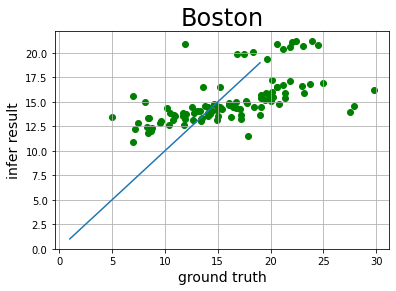

In [16]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results and ground truth: (House Price)")
    for idx, val in enumerate(zip(results[0], test_y)):
        print("%d: infer:%.2f   gt:%.2f" % (idx, val[0], val[1]))
        infer_results.append(val[0])
        groud_truths.append(val[1])
    draw_infer_result(groud_truths,infer_results)

In [17]:
import paddle.fluid as fluid
fluid.install_check.run_check()

Running Verify Fluid Program ... 
Your Paddle Fluid works well on SINGLE GPU or CPU.
Your Paddle Fluid works well on MUTIPLE GPU or CPU.
Your Paddle Fluid is installed successfully! Let's start deep Learning with Paddle Fluid now
